#EmoReflector
This project involves a social-interactive robot that provides the elderly by detecting their emotions to help them deal with it. To develop a machine-learning algorithm, PyTorch will be used.

##1. Load and Preprocess the Dataset


To load the dataset stored in google drive, the dataset must be mounted in Google Colab.

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

After mounting, the necessary packages for performing the deep-learning part must be imported as this will be used to insert into the Raspberry Pi.

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
import seaborn as sns
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2

Graphics Preprocessing Units (GPU) divides tasks into smaller sub-tasks that are distributing among several processing cores. This results in faster processing of intensive high-resolution images and graphics like the data that will be used in our project.

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

As the dataset was downloaded and not pre-installed in Pytorch, an image dataset was loaded. After loading the dataset, it has been preprocessed by removing the unnecessary column, dropping rows with missing values in 'label' column, renaming 'label' column to 'emotion' to make it clearer and finally, adding a necessary column 'is_negative' that classifies whether the emotions are negative or non-negative emotion. As our robot will only respond to negative emotions, adding 'is_negative' is a crucial step.  

In [ ]:
#csv_file = '/content/drive/My Drive/EmoReflectorfiles/facedataset.csv'
#img_dir = '/content/drive/My Drive/EmoReflectorfiles/dataset'
#csv_file = 'C:\\Users\\Administrator\\Desktop\\gp1DS\\facedataset (4).csv'
#img_dir = 'C:\\Users\\Administrator\\Desktop\\gp1DS\\dataset'
csv_file = 'C:\\Users\\Administrator\\Desktop\\gp1DS\\facedataset (4).csv'
img_dir = 'C:\\Users\\Administrator\\Desktop\\gp1DS\\dataset'

class ImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

        # Drop the 'Unnamed: 0' column if it exists
        if 'Unnamed: 0' in self.data.columns:
            self.data = self.data.drop(columns=['Unnamed: 0'])

        # Drop rows with missing values in the 'label' column and rename 'label' to 'emotion'
        self.data = self.data.dropna(subset=['label'])
        self.data = self.data.rename(columns={'label': 'emotion'})

        # Remove rows where the label is 'Ahegao'
        self.data = self.data[self.data['emotion'].str.lower() != 'ahegao']

        # Map emotions to integers
        self.emotion_to_idx = {emotion: idx for idx, emotion in enumerate(self.data['emotion'].unique())}
        self.data['emotion_idx'] = self.data['emotion'].map(self.emotion_to_idx)

        # Binary classification for is_negative (0 for non-negative, 1 for negative)
        self.data['is_negative'] = self.data['emotion'].apply(self.neg_nonneg_classifier).astype(int)

    def neg_nonneg_classifier(self, emotion):
        negative_emotions = ['angry', 'sad']
        nonnegative_emotions = ['neutral', 'happy', 'surprise']

        if emotion.lower() in negative_emotions:
            return 1
        elif emotion.lower() in nonnegative_emotions:
            return 0
        else:
            raise ValueError(f"Unexpected emotion: {emotion}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')

        # Emotion (multi-class label)
        emotion = torch.tensor(self.data.iloc[idx]['emotion_idx']).long()

        # Is_negative (binary label) should be an integer tensor (0 or 1)
        is_negative = torch.tensor(self.data.iloc[idx]['is_negative']).float().unsqueeze(0)

        if self.transform:
            image = self.transform(image)

        return image, emotion, is_negative


Transformations are necessary to enhance the performance of our machine-learning model. It resizes all the images into 128 x 128 pixels, transforms the PIL images or NumPy array into tensors to scale the values accordingly and to normalize the tensor image by adjusting the pixels with a mean = 0.5 and standard deviation = 0.5.

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

To check whether the loading and preprocessing was successful, a dataset was created and tested.

Note: Our dataset consists of 14248 files.

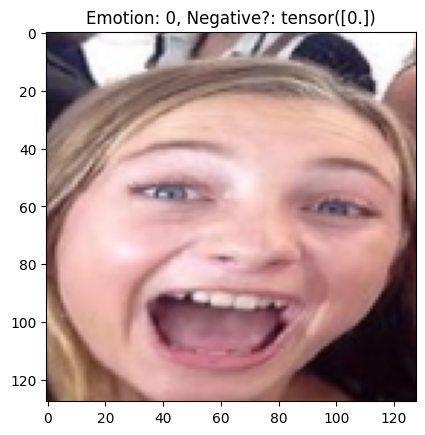

In [ ]:
# Create the dataset
dataset = ImageDataset(csv_file=csv_file, img_dir=img_dir, transform=transform)

# Testing data
image, emotion, is_negative = dataset[1000] # Choose any number from 0 to 14247

# Convert tensor to numpy array
image_np = image.permute(1, 2, 0).numpy()

# Undo/reverse normalization to make the tensor back to image
image_np = (image_np * 0.5) + 0.5

# Clip values to be between 0 and 1 (just in case, to ensure that the pixels fall within valid pixel ranges to avoid incorrect visual outputs)
image_np = np.clip(image_np, 0, 1)

# Display the image
plt.imshow(image_np)
plt.title(f"Emotion: {emotion}, Negative?: {is_negative}")
plt.show()

In the steps below, we captured the face and stored the capture to identify position of the face. And then we identify the position using Haar Cascade classifier for face detection.

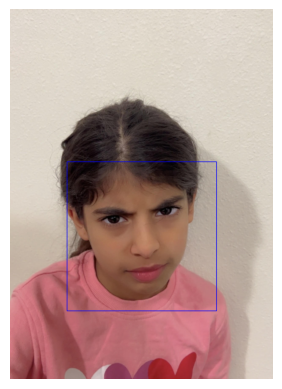

In [ ]:
# Load the Haar Cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the captured face
image_path = "C:\\Users\\Administrator\\Downloads\\im1542.jpg"
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    print(f"The image was unable to load at path: {image_path}")
else:
    # Convert the image to grayscale for face detection
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the grayscale image
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5)

    # Draw a blue rectangle around the detected faces on the original image
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Convert BGR to RGB for Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image using Matplotlib
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axes
    plt.show()


preproccess the new image

In [ ]:
# Define preprocess_image function
def preprocess_image(image_path):
    """Preprocesses an image for the model."""
    img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Resize to the model's input size
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # Normalize image
    ])
    return transform(img).unsqueeze(0)  # Add batch dimension

for balancing

In [ ]:
# Calculate class weights for "Is Negative" (binary classification)
is_negative_counts = [0, 0]  # [non-negative count, negative count]
for _, _, is_negative in dataset:
    is_negative_counts[int(is_negative)] += 1

# Calculate weights
total_samples = sum(is_negative_counts)
class_weights = [total_samples / c for c in is_negative_counts]  # Inverse frequency weighting
sample_weights = [class_weights[int(is_negative)] for _, _, is_negative in dataset]


#Defining ResNet18 Model

for balancing

In [ ]:
sample_weights = [class_weights[int(is_negative)] for _, _, is_negative in dataset]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(dataset), replacement=True)


split the train and the test dateset to 80%-20%

In [ ]:
# Set the train-test split ratio
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Define batch size and create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for balancing

In [ ]:
train_weights = [sample_weights[i] for i in range(len(train_dataset))]
sampler = WeightedRandomSampler(weights=train_weights, num_samples=len(train_dataset), replacement=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)


for balancing

In [ ]:
# Update loss functions to include weights for binary classification
criterion_emotion = nn.CrossEntropyLoss()
neg_weight = class_weights[1] / class_weights[0]  # Normalize weights for binary loss
criterion_is_negative = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([neg_weight], device=device))


define the ResNet-18 model

In [ ]:
# Define the model
class ResNetEmotionClassifier(nn.Module):
    def __init__(self, num_emotion_classes):
        super(ResNetEmotionClassifier, self).__init__()
        # Load pretrained ResNet18
        pretrained_model = models.resnet18(pretrained=True)

        # Freeze layers (optional for transfer learning)
        for param in pretrained_model.parameters():
            param.requires_grad = False

        # Use ResNet18 feature extractor
        self.feature_extractor = nn.Sequential(*list(pretrained_model.children())[:-1])

        # Add custom fully connected layers
        self.fc1 = nn.Linear(512, 256)  # ResNet18's final feature map size is 512
        self.fc2_emotion = nn.Linear(256, num_emotion_classes)  # Multi-class output
        self.fc2_is_negative = nn.Linear(256, 1)  # Binary output

    def forward(self, x):
        # Extract features using ResNet18
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)  # Flatten feature map
        x = F.relu(self.fc1(x))
        emotion_output = self.fc2_emotion(x)
        is_negative_output = self.fc2_is_negative(x)
        return emotion_output, is_negative_output

# Initialize the model
num_emotion_classes = 5
model = ResNetEmotionClassifier(num_emotion_classes).to(device)


c:\ProgramData\anaconda3\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


function loss and optimizer

In [ ]:
criterion_emotion = nn.CrossEntropyLoss()  # Multi-class classification
criterion_is_negative = nn.BCEWithLogitsLoss()  # Binary classification

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)

In [ ]:
for param in model.feature_extractor[6:].parameters():  # Unfreeze deeper layers
    param.requires_grad = True


train the dataset

In [ ]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, emotions, is_negatives in train_loader:
        # Move data to device
        images = images.to(device)
        emotions = emotions.to(device)

        # Reshape and ensure is_negatives has shape (batch_size, 1)
        is_negatives = is_negatives.float().to(device)  # Convert to float and move to device
        is_negatives = is_negatives.view(-1, 1)  # Flatten to (batch_size, 1)

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        emotion_output, is_negative_output = model(images)

        # Compute losses
        loss_emotion = criterion_emotion(emotion_output, emotions)
        loss_is_negative = criterion_is_negative(is_negative_output, is_negatives)

        # Combine losses and backpropagate
        loss = loss_emotion + loss_is_negative
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/20, Loss: 1.1139
Epoch 2/20, Loss: 0.5151
Epoch 3/20, Loss: 0.2807
Epoch 4/20, Loss: 0.2486
Epoch 5/20, Loss: 0.1443
Epoch 6/20, Loss: 0.1466
Epoch 7/20, Loss: 0.0684
Epoch 8/20, Loss: 0.0492
Epoch 9/20, Loss: 0.1406
Epoch 10/20, Loss: 0.0665
Epoch 11/20, Loss: 0.0297
Epoch 12/20, Loss: 0.0330
Epoch 13/20, Loss: 0.0253
Epoch 14/20, Loss: 0.0276
Epoch 15/20, Loss: 0.0480
Epoch 16/20, Loss: 0.1511
Epoch 17/20, Loss: 0.0825
Epoch 18/20, Loss: 0.0816
Epoch 19/20, Loss: 0.0874
Epoch 20/20, Loss: 0.0419


calculate the accuracy

In [ ]:
model.eval()
correct_emotion = 0
correct_is_negative = 0
total_samples = 0

with torch.no_grad():
    for images, emotions, is_negatives in test_loader:
        # Move data to device
        images = images.to(device)
        emotions = emotions.to(device)
        is_negatives = is_negatives.float().view(-1, 1).to(device)  # Ensure shape (batch_size, 1)

        # Model forward pass
        emotion_output, is_negative_output = model(images)

        # Multi-class classification
        _, predicted_emotions = torch.max(emotion_output, 1)
        correct_emotion += (predicted_emotions == emotions).sum().item()

        # Binary classification
        predicted_is_negative = (is_negative_output > 0.5).float()
        correct_is_negative += (predicted_is_negative == is_negatives).sum().item()

        # Update total samples
        total_samples += images.size(0)

# Calculate accuracies
emotion_accuracy = 100 * correct_emotion / total_samples
is_negative_accuracy = 100 * correct_is_negative / (total_samples * 1)  # Ensure binary total matches

print(f"Emotion Classification Accuracy: {emotion_accuracy:.2f}%")
print(f"Is Negative Classification Accuracy: {is_negative_accuracy:.2f}%")


Emotion Classification Accuracy: 77.65%
Is Negative Classification Accuracy: 84.49%


Testing

preformence metrics

Emotion Classification Metrics:
F1 Score: 0.7756
Precision: 0.7758
Recall: 0.7765
Accuracy: 0.7765
Confusion Matrix:
[[173  14  22  31   4]
 [ 12 577  18 131  29]
 [ 11  15 711  24   3]
 [ 18 175  32 563  33]
 [  5  29   5  26 189]]

Is_Negative Classification Metrics:
F1 Score: 0.7906
Precision: 0.7775
Recall: 0.8041
Accuracy: 0.8474
Confusion Matrix:
[[1594  235]
 [ 200  821]]


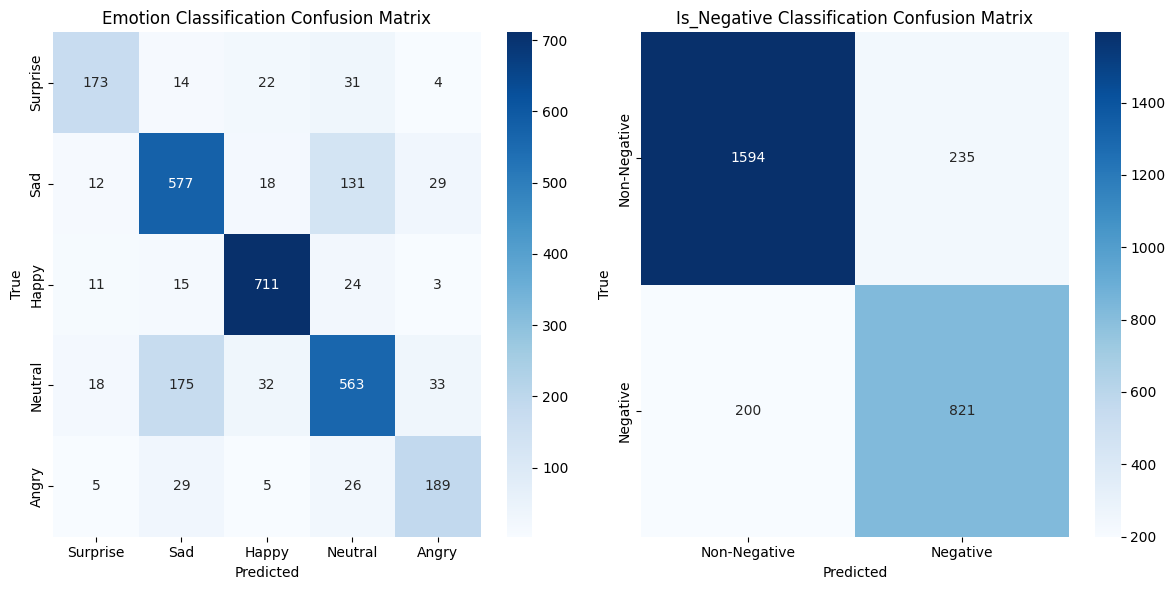

In [ ]:
# Put the model in evaluation mode
model.eval()

# Initialize lists to store ground truths and predictions
true_emotions = []
pred_emotions = []
true_is_negatives = []
pred_is_negatives = []

# No gradient computation during evaluation
with torch.no_grad():
    for images, emotions, is_negatives in test_loader:
        # Move data to device
        images = images.to(device)
        emotions = emotions.to(device)
        is_negatives = is_negatives.float().to(device).view(-1, 1)

        # Forward pass
        emotion_output, is_negative_output = model(images)

        # Get predictions
        pred_emotions_batch = torch.argmax(emotion_output, dim=1).cpu().numpy()
        pred_is_negatives_batch = (torch.sigmoid(is_negative_output) > 0.5).cpu().numpy().astype(int)

        # Append ground truths and predictions to the lists
        true_emotions.extend(emotions.cpu().numpy())
        pred_emotions.extend(pred_emotions_batch)
        true_is_negatives.extend(is_negatives.cpu().numpy().flatten())
        pred_is_negatives.extend(pred_is_negatives_batch.flatten())

# Convert lists to numpy arrays
true_emotions = np.array(true_emotions)
pred_emotions = np.array(pred_emotions)
true_is_negatives = np.array(true_is_negatives)
pred_is_negatives = np.array(pred_is_negatives)

# Calculate metrics for emotion classification
emotion_f1 = f1_score(true_emotions, pred_emotions, average='weighted')
emotion_precision = precision_score(true_emotions, pred_emotions, average='weighted')
emotion_recall = recall_score(true_emotions, pred_emotions, average='weighted')
emotion_accuracy = accuracy_score(true_emotions, pred_emotions)
emotion_cm = confusion_matrix(true_emotions, pred_emotions)

# Calculate metrics for is_negative classification
is_negative_f1 = f1_score(true_is_negatives, pred_is_negatives)
is_negative_precision = precision_score(true_is_negatives, pred_is_negatives)
is_negative_recall = recall_score(true_is_negatives, pred_is_negatives)
is_negative_accuracy = accuracy_score(true_is_negatives, pred_is_negatives)
is_negative_cm = confusion_matrix(true_is_negatives, pred_is_negatives)

# Display results
print("Emotion Classification Metrics:")
print(f"F1 Score: {emotion_f1:.4f}")
print(f"Precision: {emotion_precision:.4f}")
print(f"Recall: {emotion_recall:.4f}")
print(f"Accuracy: {emotion_accuracy:.4f}")
print("Confusion Matrix:")
print(emotion_cm)

print("\nIs_Negative Classification Metrics:")
print(f"F1 Score: {is_negative_f1:.4f}")
print(f"Precision: {is_negative_precision:.4f}")
print(f"Recall: {is_negative_recall:.4f}")
print(f"Accuracy: {is_negative_accuracy:.4f}")
print("Confusion Matrix:")
print(is_negative_cm)

# Plot confusion matrices
plt.figure(figsize=(12, 6))

# Emotion classification confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(emotion_cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.emotion_to_idx.keys(), yticklabels=dataset.emotion_to_idx.keys())
plt.title("Emotion Classification Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

# Is_negative classification confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(is_negative_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Negative", "Negative"], yticklabels=["Non-Negative", "Negative"])
plt.title("Is_Negative Classification Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.tight_layout()
plt.show()


evaluate the mod with th new image and print the result

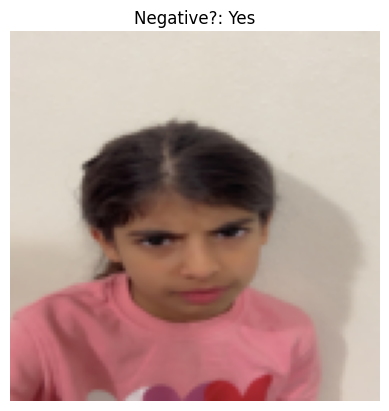

In [ ]:
model.eval()

# Load and preprocess the image
image = preprocess_image(image_path).to(device)

# Forward pass through the model
emotion_output, is_negative_output = model(image)

# Get the predicted emotion (multi-class classification)
_, predicted_emotion_idx = torch.max(emotion_output, 1)

# Get the predicted emotion as a label
emotion_labels = {idx: emotion for emotion, idx in dataset.emotion_to_idx.items()}
predicted_emotion = emotion_labels[predicted_emotion_idx.item()]

# Get the binary "is negative" prediction (binary classification)
is_negative_pred = (torch.sigmoid(is_negative_output) > 0.5).item()

# Convert tensor to numpy array for display
image_np = image.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Remove batch dimension and rearrange channels
image_np = (image_np * 0.5) + 0.5  # Reverse normalization
image_np = np.clip(image_np, 0, 1)  # Clip values to ensure they are between 0 and 1

# Display the image with the predicted emotion
plt.imshow(image_np)
plt.title(f"Negative?: {'Yes' if is_negative_pred else 'No'}")
plt.axis('off')  # Hide axes
plt.show()

This is to walkthrough how many contents are in our image data directory (extra information).

test one image from the test dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].


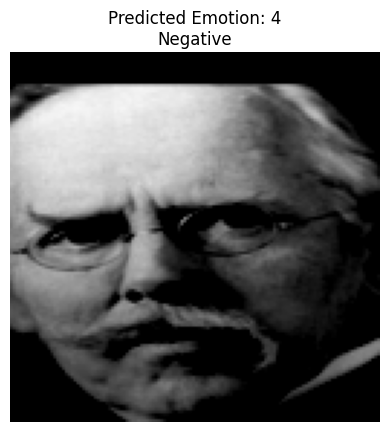

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display an image with prediction
def show_image_with_prediction(model, dataset, index, device):
    # Set the model to evaluation mode
    model.eval()

    # Get the image and labels from the dataset at the specified index
    image, true_emotion, true_is_negative = dataset[index]
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    with torch.no_grad():
        # Get model predictions
        emotion_output, is_negative_output = model(image)

        # Process predictions
        _, predicted_emotion = torch.max(emotion_output, 1)
        is_negative_pred = (is_negative_output > 0.5).float()

        # Convert tensors to CPU for display
        image_np = image.squeeze(0).cpu().numpy().transpose((1, 2, 0))

        # Display the image
        plt.imshow(image_np)
        plt.axis('off')

        # Show the predicted emotion and negative/positive prediction
        emotion_text = f"Predicted Emotion: {predicted_emotion.item()}"
        neg_pos_text = "Negative" if is_negative_pred.item() == 1 else "Non-negative"
        plt.title(f"{emotion_text}\n{neg_pos_text}")
        plt.show()

# Example usage - Show an image with prediction
index_to_display = 56 # Change this index to display different images
show_image_with_prediction(model, test_dataset, index_to_display, device)


In [ ]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(img_dir)

There are 5 directories and 0 images in '/content/drive/My Drive/EmoReflectorfiles/dataset'.
There are 0 directories and 1313 images in '/content/drive/My Drive/EmoReflectorfiles/dataset/Angry'.
There are 0 directories and 3934 images in '/content/drive/My Drive/EmoReflectorfiles/dataset/Sad'.
There are 0 directories and 1234 images in '/content/drive/My Drive/EmoReflectorfiles/dataset/Surprise'.
There are 0 directories and 4027 images in '/content/drive/My Drive/EmoReflectorfiles/dataset/Neutral'.
There are 0 directories and 3740 images in '/content/drive/My Drive/EmoReflectorfiles/dataset/Happy'.
